# Chocolate Sales Forecasting — Exploratory Data Analysis (EDA)

This notebook focuses on understanding and preparing the Chocolate Sales dataset for forecasting.  
It covers:
- Loading and inspecting the raw dataset (schema, missing values, duplicates)
- Cleaning key columns (parsing `Date`, converting `Amount` from `$` format to numeric)
- Creating derived metrics like `Amount_per_box`
- Exploring trends and seasonality through monthly/yearly aggregations
- Visual exploration by country/product (top contributors, distributions, and outliers)

**Output:** a cleaned dataset that can be reused in modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/Chocolate-Sales.csv")

df.info()
df.head(10)

<class 'pandas.DataFrame'>
RangeIndex: 3282 entries, 0 to 3281
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Sales Person   3282 non-null   str  
 1   Country        3282 non-null   str  
 2   Product        3282 non-null   str  
 3   Date           3282 non-null   str  
 4   Amount         3282 non-null   str  
 5   Boxes Shipped  3282 non-null   int64
dtypes: int64(1), str(5)
memory usage: 154.0 KB


,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,"$5,320.00",180
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,"$7,896.00",94
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,"$4,501.00",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27/04/2022,"$12,726.00",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24/02/2022,"$13,685.00",184
5,Van Tuxwell,India,Smooth Sliky Salty,06/06/2022,"$5,376.00",38
6,Oby Sorrel,UK,99% Dark & Pure,25/01/2022,"$13,685.00",176
7,Gunar Cockshoot,Australia,After Nines,24/03/2022,"$3,080.00",73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,20/04/2022,"$3,990.00",59
9,Brien Boise,Australia,99% Dark & Pure,04/07/2022,"$2,835.00",102


In [2]:
print(f"--- Countries :\n {df["Country"].unique().tolist()}\n")
print(f"--- Products :\n {df["Product"].unique()}")

--- Countries :
 ['UK', 'India', 'Australia', 'New Zealand', 'USA', 'Canada']

--- Products :
 <StringArray>
[     'Mint Chip Choco',        '85% Dark Bars',  'Peanut Butter Cubes',
   'Smooth Sliky Salty',      '99% Dark & Pure',          'After Nines',
       '50% Dark Bites',         'Orange Choco',              'Eclairs',
        'Drinking Coco',  'Organic Choco Syrup',            'Milk Bars',
  'Spicy Special Slims',     'Fruit & Nut Bars',           'White Choc',
   'Manuka Honey Choco',         'Almond Choco',      'Raspberry Choco',
 'Choco Coated Almonds',  'Baker's Choco Chips', 'Caramel Stuffed Bars',
       '70% Dark Bites']
Length: 22, dtype: str


In [3]:
# Transforming Amount to float : "$5,320.00" -> 5320.00
df["Amount"] = (
    df["Amount"].astype(str)
    .str.replace(r"[\$,]", "", regex=True)   # remove $ and commas
    .str.strip()
)
df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")
df["Amount"].head()

0     5320.0
1     7896.0
2     4501.0
3    12726.0
4    13685.0
Name: Amount, dtype: float64

In [4]:
df["Amount_per_box"] = np.where( # To avoid division by 0
    df["Boxes Shipped"] != 0,
    df["Amount"] / df["Boxes Shipped"],
    np.nan
) 
df.drop(columns="Sales Person",inplace=True) # Irrelevent feature

df.head()

,Country,Product,Date,Amount,Boxes Shipped,Amount_per_box
0,UK,Mint Chip Choco,04/01/2022,5320.0,180,29.555556
1,India,85% Dark Bars,01/08/2022,7896.0,94,84.000000
2,India,Peanut Butter Cubes,07/07/2022,4501.0,91,49.461538
3,Australia,Peanut Butter Cubes,27/04/2022,12726.0,342,37.210526
4,UK,Peanut Butter Cubes,24/02/2022,13685.0,184,74.375000


In [5]:
# Transforming "Date" to datetime
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df.head()

,Country,Product,Date,Amount,Boxes Shipped,Amount_per_box
0,UK,Mint Chip Choco,2022-01-04,5320.0,180,29.555556
1,India,85% Dark Bars,2022-08-01,7896.0,94,84.000000
2,India,Peanut Butter Cubes,2022-07-07,4501.0,91,49.461538
3,Australia,Peanut Butter Cubes,2022-04-27,12726.0,342,37.210526
4,UK,Peanut Butter Cubes,2022-02-24,13685.0,184,74.375000


In [6]:
# Monthly stats

df["Month"] = df["Date"].dt.month
df["Month_Name"] = df["Date"].dt.month_name()

monthly_summary = (
    df.groupby(["Month", "Month_Name"], as_index=False)
           .agg(revenue=("Amount", "sum"),
                boxes=("Boxes Shipped", "sum"),
                avg_price=("Amount_per_box", "mean"),
                n_rows=("Amount", "size"))
           .sort_values("Month")
)

monthly_summary

,Month,Month_Name,revenue,boxes,avg_price,n_rows
0,1,January,2868712.59,84162,95.049285,462
1,2,February,2232096.90,54917,82.031246,330
2,3,March,2404769.29,59633,146.587162,393
3,4,April,2161927.22,64216,98.053886,354
4,5,May,2415750.57,66662,100.070694,405
5,6,June,2773931.94,80357,112.303021,489
6,7,July,2567532.29,69808,111.045471,447
7,8,August,2366851.06,60682,141.874018,402


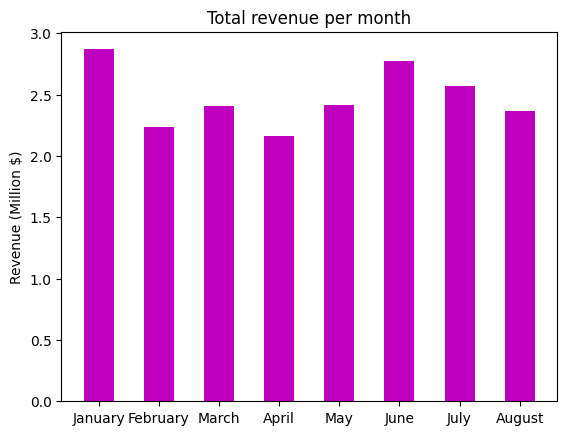

In [7]:
fig, ax = plt.subplots()

months = monthly_summary["Month_Name"].tolist()
revenue_per_month = (monthly_summary["revenue"]/10**6).tolist()


ax.bar(months, revenue_per_month, width=0.5, color='m')
ax.set_ylabel('Revenue (Million $)')
ax.set_title('Total revenue per month')

plt.show()

In [8]:
# Yearly stats

df["Year"] = df["Date"].dt.year

yearly_summary = (
    df.groupby(["Year"], as_index=False)
           .agg(revenue=("Amount", "sum"),
                boxes=("Boxes Shipped", "sum"),
                avg_price=("Amount_per_box", "mean"),
                n_rows=("Amount", "size"))
           .sort_values("Year")
)

yearly_summary

,Year,revenue,boxes,avg_price,n_rows
0,2022,6183625.00,177007,105.720204,1094
1,2023,6643377.96,181411,111.552139,1094
2,2024,6964568.90,182019,116.748132,1094


Text(0.5, 1.0, 'Yearly boxes sold')

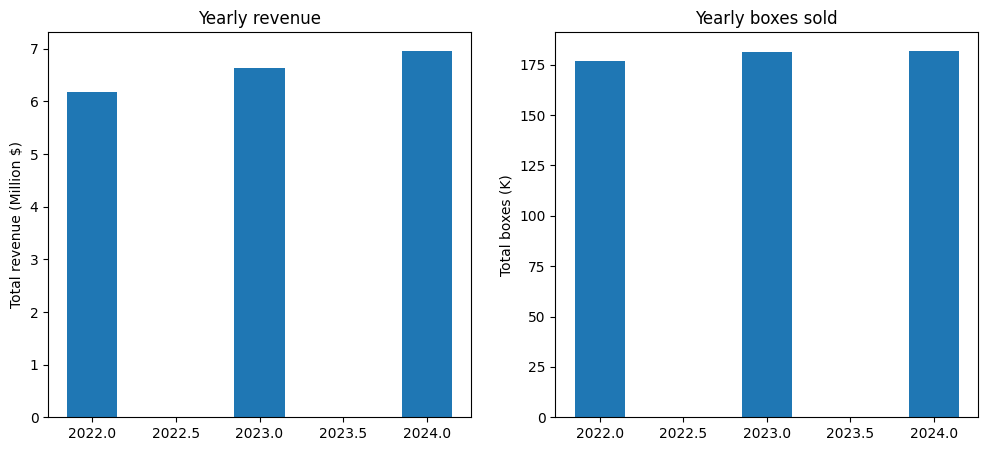

In [16]:
years = df["Date"].dt.year.unique().tolist()

int_years = []
for year in years : 
    int_years.append(int(year))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].bar(int_years, yearly_summary["revenue"]/10**6, width=0.3)
ax[0].set_ylabel("Total revenue (Million $)")
ax[0].set_title("Yearly revenue")

ax[1].bar(int_years, yearly_summary["boxes"]/10**3, width=0.3)
ax[1].set_ylabel("Total boxes (K)")
ax[1].set_title("Yearly boxes sold")


In [10]:
df.to_csv("../data/processed_data.csv", index=False)